### Overview of this notebook

* why transformers? transformers in `sktime`

    * transformers = modular data processing steps
    * simple pipeline example & transformer explained

* overview of transformer features

    * types of transformers - input types, output types
    * broadcasting/vectorization to panel, hierarchical, multivariate
    * searching for transformers using `all_estimators`

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Table of Contents

* [3. Transformers in sktime](#chapter3)
    * [3.1 Wherefore transformers?](#section_3_1)
    * [3.2 Transformers - interface and features](#section_3_2)
        * [3.2.1 What are transformers?](#section_3_2_1)
        * [3.2.2 Different types of transformers](#section_3_2_2)
        * [3.2.3 Broadcasting aka vectorization of transformers](#section_3_2_3)         
        * [3.2.4 Transformers as pipeline components](#section_3_2_4)
    * [3.3 Combining transformers, feature engineering](#section_3_3) 
    * [3.4 Technical details - transformer types and signatures](#section_3_4)
    * [3.5 Extension guide](#section_3_5)        
    * [3.6 Summary](#section_3_6) 

---

# 3. Transformers in `sktime` <a class="anchor" id="chapter3"></a>

## 3.1 Wherefore transformers? <a class="anchor" id="section_3_1"></a>

or: why sktime transformers will improve your life!

(disclaimer: not the same product as deep learning transformers)

suppose we want to forecast this well-known dataset
(airline passengers by year in a fixed scope)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

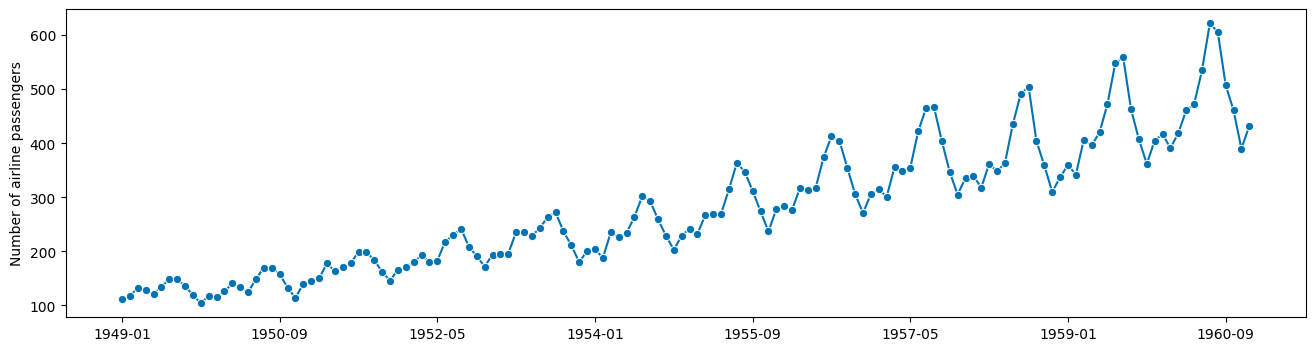

In [2]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()
plot_series(y)

observations:

* there is seasonal periodicity, 12 month period
* seasonal periodicity looks multiplicative (not additive) to trend

idea: forecast might be easier

* with seasonality removed
* on logarithmic value scale (multiplication becomes addition)

### Naive approach - don't do this at home!

Maybe doing this manually step by step is a good idea?

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

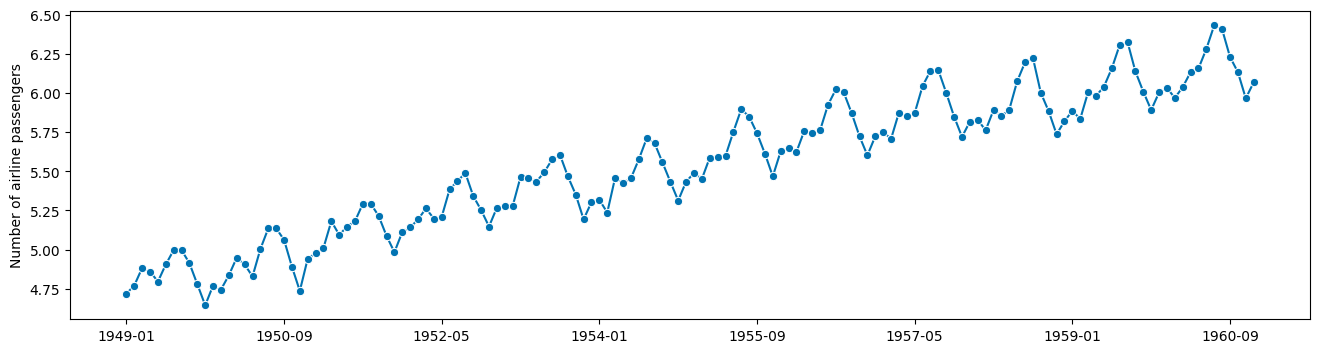

In [3]:
import numpy as np

# compute the logarithm
logy = np.log(y)

plot_series(logy)

this looks additive now!

ok, what next - deaseasonalization

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# apply this to y
# wait no, to logy

seasonal_result = seasonal_decompose(logy, period=12)

trend = seasonal_result.trend
resid = seasonal_result.resid
seasonal = seasonal_result.seasonal

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='trend'>)

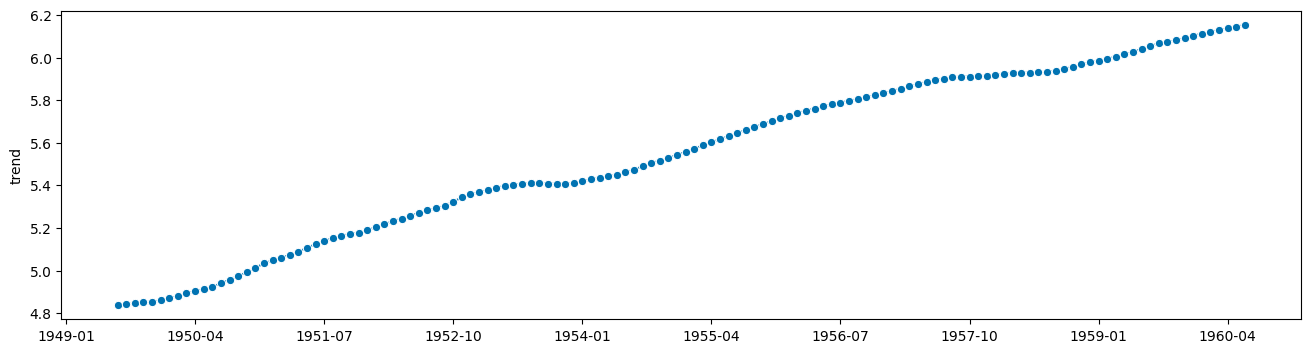

In [5]:
plot_series(trend)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='seasonal'>)

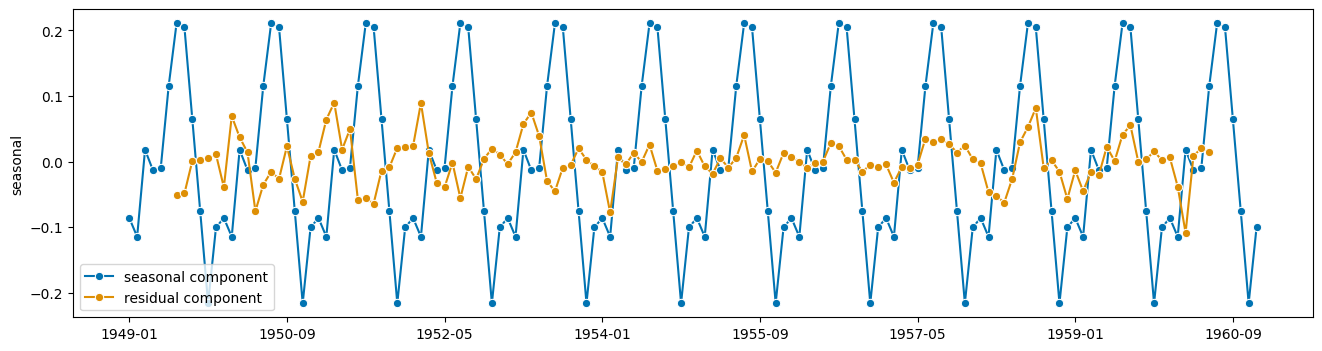

In [6]:
plot_series(seasonal, resid, labels=["seasonal component", "residual component"])

ok, now the forecast!

... of what ??

ah yes, residual plus trend, because seasonal just repeats itself

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

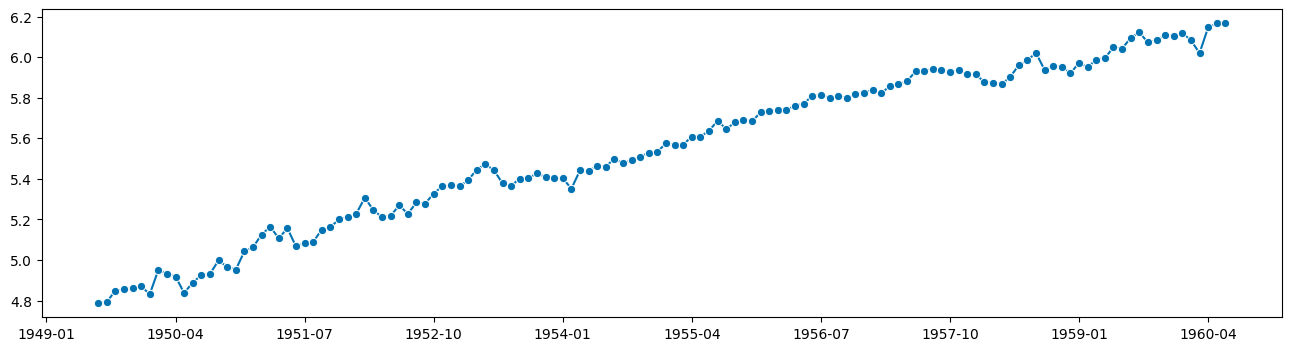

In [7]:
# forecast this:
plot_series(trend + resid)

In [8]:
# this has nans??
trend

1949-01   NaN
1949-02   NaN
1949-03   NaN
1949-04   NaN
1949-05   NaN
           ..
1960-08   NaN
1960-09   NaN
1960-10   NaN
1960-11   NaN
1960-12   NaN
Freq: M, Name: trend, Length: 144, dtype: float64

In [9]:
# ok, forecast this instead then:
y_to_forecast = logy - seasonal

# phew, no nans!
y_to_forecast

1949-01    4.804314
1949-02    4.885097
1949-03    4.864689
1949-04    4.872858
1949-05    4.804757
             ...   
1960-08    6.202368
1960-09    6.165645
1960-10    6.208669
1960-11    6.181992
1960-12    6.168741
Freq: M, Length: 144, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

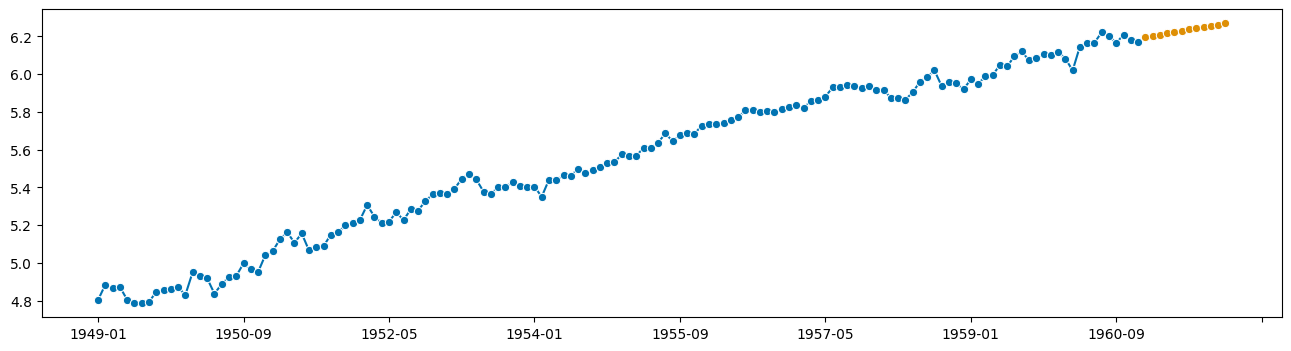

In [10]:
from sktime.forecasting.trend import PolynomialTrendForecaster

f = PolynomialTrendForecaster(degree=2)
f.fit(y_to_forecast, fh=list(range(1, 13)))
y_fcst = f.predict()

plot_series(y_to_forecast, y_fcst)

looks reasonable!

Now to turn this into a forecast of the original y ...

* add seasonal
* invert the logarithm

In [11]:
y_fcst

1961-01    6.195931
1961-02    6.202857
1961-03    6.209740
1961-04    6.216580
1961-05    6.223378
1961-06    6.230132
1961-07    6.236843
1961-08    6.243512
1961-09    6.250137
1961-10    6.256719
1961-11    6.263259
1961-12    6.269755
Freq: M, dtype: float64

In [12]:
y_fcst_orig = y_fcst + seasonal[0:12]
y_fcst_orig_orig = np.exp(y_fcst_orig)

y_fcst_orig_orig

1949-01   NaN
1949-02   NaN
1949-03   NaN
1949-04   NaN
1949-05   NaN
1949-06   NaN
1949-07   NaN
1949-08   NaN
1949-09   NaN
1949-10   NaN
1949-11   NaN
1949-12   NaN
1961-01   NaN
1961-02   NaN
1961-03   NaN
1961-04   NaN
1961-05   NaN
1961-06   NaN
1961-07   NaN
1961-08   NaN
1961-09   NaN
1961-10   NaN
1961-11   NaN
1961-12   NaN
Freq: M, dtype: float64

ok, that did not work. Something something pandas indices??

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

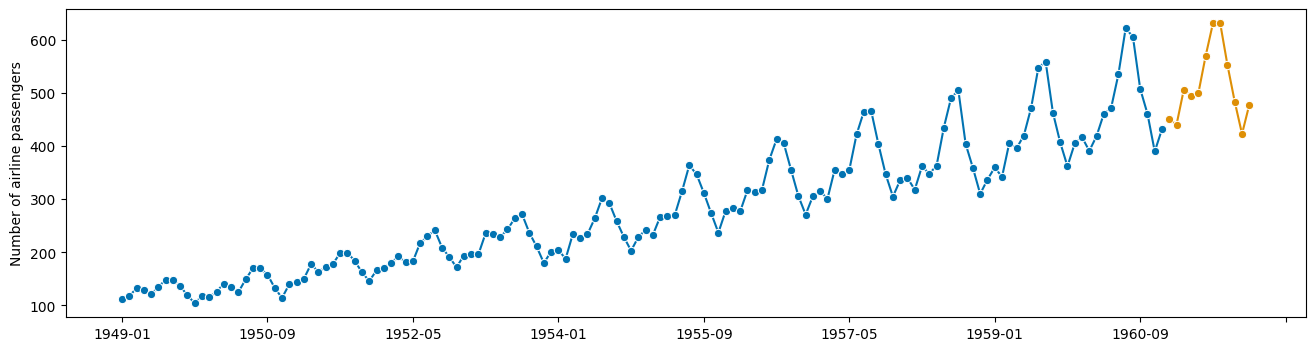

In [13]:
y_fcst_orig = y_fcst + seasonal[0:12].values
y_fcst_orig_orig = np.exp(y_fcst_orig)

plot_series(y, y_fcst_orig_orig)

ok, done! and it only took us 10 years.

Maybe there is a better way?

### Slightly less naive approach - use `sktime` transformers (badly)

Ok, surely there is a way where I don't have to fiddle with wildly varying interfaces of every step.

Solution: use transformers!

Same interface at every step!

In [14]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

t_log = LogTransformer()
ylog = t_log.fit_transform(y)

t_deseason = Deseasonalizer(sp=12)
y_deseason = t_deseason.fit_transform(ylog)

f = PolynomialTrendForecaster(degree=2)
f.fit(y_deseason, fh=list(range(1, 13)))
y_fcst = f.predict()

hm, but now we need to invert the transformations...

fortunately transformers have an inverse transform, standard interface point

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

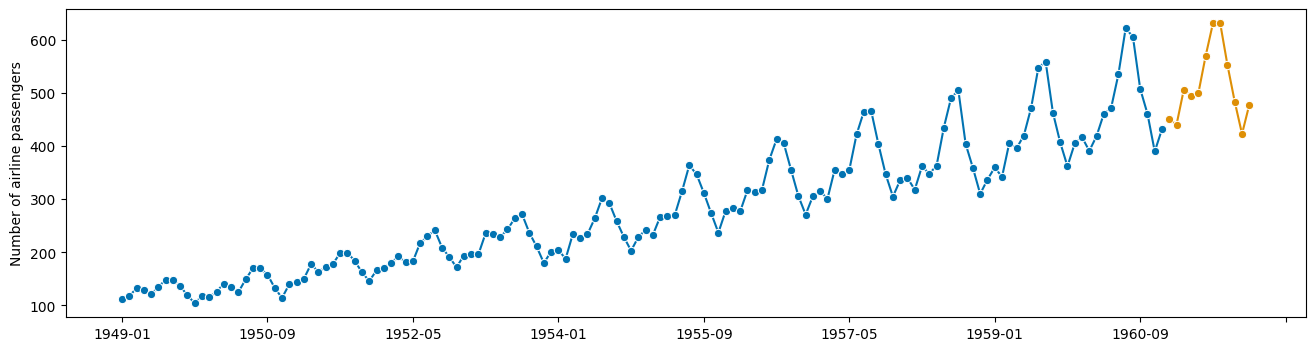

In [15]:
y_fcst_orig = t_deseason.inverse_transform(y_fcst)
# the deseasonalizer remembered the seasonality component! nice!

y_fcst_orig_orig = t_log.inverse_transform(y_fcst_orig)

plot_series(y, y_fcst_orig_orig)

### Expert approach - use `sktime` transformers with pipelines!

Bragging rights included.

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

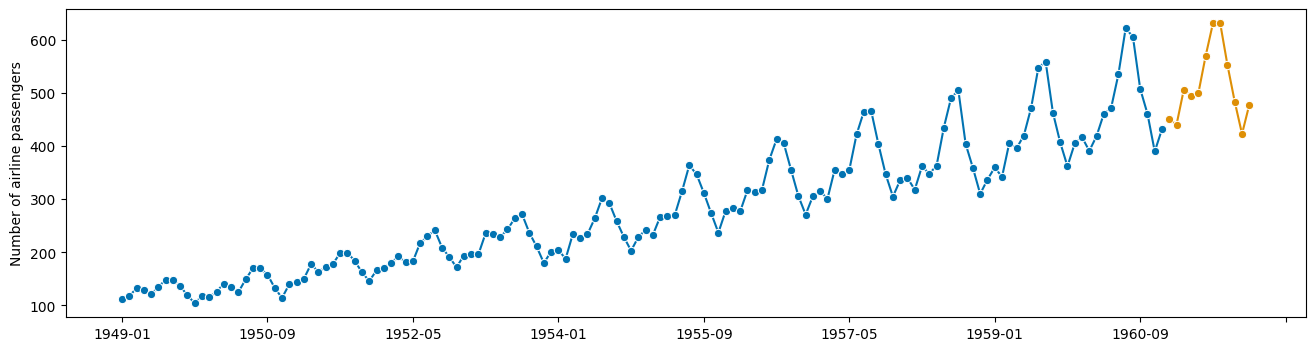

In [16]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

f = LogTransformer() * Deseasonalizer(sp=12) * PolynomialTrendForecaster(degree=2)

f.fit(y, fh=list(range(1, 13)))
y_fcst = f.predict()

plot_series(y, y_fcst)

what happened here?

The "chain" operator `*` creates a "forecasting pipeline"

Has the same interface as all other forecasters! No additional data fiddling!

Transformers "slot in" as standardized components.

In [17]:
f

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   PolynomialTrendForecaster(degree=2)])

Let's look at this in more detail:

* `sktime` transformers interface
* `sktime` pipeline building

## 3.2 Transformers - interface and features <a class="anchor" id="section_3_2"></a>

* transformer interface
* transformer types
* searching transformers by type
* broadcasting/vectorization to panel & hierarchical data
* transformers and pipelines

### 3.2.1 What are transformers? <a class="anchor" id="section_3_2_1"></a>

Transformer = modular data processing steps commonly used in machine learning

("transformer" used in the sense of `scikit-learn`)

Transformers are estimators that:

* are fitted to a batch of data via `fit(data)`, changing its state
* are applied to another batch of data via `transform(X)`, producing transformed data
* may have an `inverse_transform(X)`

In `sktime`, input `X` to `fit` and `transform` is typically a time series or a panel (collection of time series).

Basic use of an `sktime` time series transformer is as follows:

In [18]:
# 1. prepare the data
from sktime.utils._testing.series import _make_series

X = _make_series()
X_train = X[:7]
X_test = X[7:12]
# X_train and X_test are both pandas.Series

X_train, X_test

(2000-01-01    4.708975
 2000-01-02    1.803052
 2000-01-03    2.403074
 2000-01-04    3.076577
 2000-01-05    2.902616
 2000-01-06    3.831219
 2000-01-07    2.121627
 Freq: D, dtype: float64,
 2000-01-08    4.858755
 2000-01-09    3.460329
 2000-01-10    2.280978
 2000-01-11    1.930733
 2000-01-12    4.604839
 Freq: D, dtype: float64)

In [19]:
# 2. construct the transformer
from sktime.transformations.series.boxcox import BoxCoxTransformer

# trafo is an sktime estimator inheriting from BaseTransformer
# Box-Cox transform with lambda parameter fitted via mle
trafo = BoxCoxTransformer(method="mle")

In [20]:
# 3. fit the transformer to training data
trafo.fit(X_train)

# 4. apply the transformer to transform test data
# Box-Cox transform with lambda fitted on X_train
X_transformed = trafo.transform(X_test)

X_transformed

2000-01-08    1.242107
2000-01-09    1.025417
2000-01-10    0.725243
2000-01-11    0.593567
2000-01-12    1.209380
Freq: D, dtype: float64

If the training and test set is the same, step 3 and 4 can be carried out more concisely (and sometimes more efficiently) by using `fit_transform`:

In [21]:
# 3+4. apply the transformer to fit and transform on the same data, X
X_transformed = trafo.fit_transform(X)

### 3.2.2 Different types of transformers <a class="anchor" id="section_3_2_2"></a>

`sktime` distinguishes different types of transformer, depending on the input type of `fit` and `transform`, and the output type of `transform`.

Transformers differ by:

* making use of an additional `y` argument in `fit` or `transform`
* whether the input to `fit` and `transform` is a single time series, a collection of time series, or scalar values (data frame row)
* whether the output of `transform` is a single time series, a collection of time series, or scalar values (data frame row)
* whether the input to `fit` and `transform` are one object or two. Two objects as input and a scalar output means the transformer is a distance or kernel function.

More detail on this is given in the glossary (section 2.3).

To illustrate the difference, we compare two transformers with different output:

* the Box-Cox transformer `BoxCoxTrannsformer`, which transforms a time series to a time series
* the summary transformer `SummaryTransformer`, which transforms a time series to scalars such as the mean


In [22]:
# constructing the transformer
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.summarize import SummaryTransformer
from sktime.utils._testing.series import _make_series

# getting some data
# this is one pandas.Series
X = _make_series(n_timepoints=10)

# constructing the transformers
boxcox_trafo = BoxCoxTransformer(method="mle")
summary_trafo = SummaryTransformer()

In [23]:
# this produces a pandas Series
boxcox_trafo.fit_transform(X)

2000-01-01    3.217236
2000-01-02    6.125564
2000-01-03    5.264381
2000-01-04    3.811121
2000-01-05    1.966839
2000-01-06    2.621609
2000-01-07    3.851400
2000-01-08    3.199416
2000-01-09    0.000000
2000-01-10    6.629380
Freq: D, dtype: float64

In [24]:
# this produces a pandas.DataFrame row
summary_trafo.fit_transform(X)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,3.368131,1.128705,1.0,4.881081,2.339681,2.963718,3.376426,4.0816,4.67824


For time series transformers, the metadata tags describe the expected output of `transform`:

In [25]:
boxcox_trafo.get_tag("scitype:transform-output")

'Series'

In [26]:
summary_trafo.get_tag("scitype:transform-output")

'Primitives'

To find transformers, use `all_estimators` and filter by tags:

* `"scitype:transform-output"` - the output scitype. `Series` for time series, `Primitives` for primitive features (float, categories), `Panel` for collections of time series.
* `"scitype:transform-input"` - the input scitype. `Series` for time series.
* `"scitype:instancewise"` - If `True`, vectorized operation per series. If `False`, uses multiple time series non-trivially.

Example: find all transformers that output time series

In [27]:
from sktime.registry import all_estimators

# now subset to transformers that extract scalar features
all_estimators(
    "transformer",
    as_dataframe=True,
    filter_tags={"scitype:transform-output": "Series"},
)

Importing plotly failed. Interactive plots will not work.


,name,estimator
0,Aggregator,<class 'sktime.transformations.hierarchical.ag...
1,AutoCorrelationTransformer,<class 'sktime.transformations.series.acf.Auto...
2,BoxCoxTransformer,<class 'sktime.transformations.series.boxcox.B...
3,ClaSPTransformer,<class 'sktime.transformations.series.clasp.Cl...
4,ClearSky,<class 'sktime.transformations.series.clear_sk...
...,...,...
69,TransformerPipeline,<class 'sktime.transformations.compose.Transfo...
70,TruncationTransformer,<class 'sktime.transformations.panel.truncatio...
71,WhiteNoiseAugmenter,<class 'sktime.transformations.series.augmente...
72,WindowSummarizer,<class 'sktime.transformations.series.summariz...


A more complete overview on transformer types and tags is given in the `sktime` transformers tutorial.


### 3.2.3 Broadcasting aka vectorization of transformers <a class="anchor" id="section_3_2_3"></a>

`sktime` transformers may be natively univariate, or apply only to a single time series.

Even if this is the case, they broadcast across variables and instances of time series, where applicable (also known as vectorization in `numpy` parlance).

This ensures that all `sktime` transformers can be applied to multivariate and multi-instance (panel, hierarchical) time series data.

Example 1: broadcasting/vectorization of time series to time series transformer

The `BoxCoxTransformer` from previous sections applies to single instances of univariate time series. When multiple instances or variables are seen, it broadcasts across both:

In [28]:
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.utils._testing.hierarchical import _make_hierarchical

# hierarchical data with 2 variables and 2 levels
X = _make_hierarchical(n_columns=2)

X

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  3.068024  3.177475
          2000-01-02  2.917533  3.615065
          2000-01-03  3.654595  3.327944
          2000-01-04  2.848652  4.694433
          2000-01-05  3.458690  3.349914
...                        ...       ...
h0_1 h1_3 2000-01-08  4.056444  3.726508
          2000-01-09  2.462253  3.938115
          2000-01-10  2.689640  1.000000
          2000-01-11  1.233706  3.999155
          2000-01-12  3.101318  3.632666

[96 rows x 2 columns]

In [29]:
# constructing the transformers
boxcox_trafo = BoxCoxTransformer(method="mle")

# applying to X results in hierarchical data
boxcox_trafo.fit_transform(X)

c0         c1
h0   h1   time                           
h0_0 h1_0 2000-01-01  0.307301   3.456645
          2000-01-02  0.305723   4.416187
          2000-01-03  0.311191   3.777609
          2000-01-04  0.304881   7.108861
          2000-01-05  0.310189   3.825267
...                        ...        ...
h0_1 h1_3 2000-01-08  1.884165   9.828613
          2000-01-09  1.087370  11.311330
          2000-01-10  1.216886   0.000000
          2000-01-11  0.219210  11.761224
          2000-01-12  1.435712   9.208733

[96 rows x 2 columns]

Fitted model components of vectorized transformers can be found in the `transformers_` attribute, or accessed via the universal `get_fitted_params` interface:

In [30]:
boxcox_trafo.transformers_
# this is a pandas.DataFrame that contains the fitted transformers
# one per time series instance and variable

c0                   c1
h0   h1                                            
h0_0 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
     h1_1  BoxCoxTransformer()  BoxCoxTransformer()
     h1_2  BoxCoxTransformer()  BoxCoxTransformer()
     h1_3  BoxCoxTransformer()  BoxCoxTransformer()
h0_1 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
     h1_1  BoxCoxTransformer()  BoxCoxTransformer()
     h1_2  BoxCoxTransformer()  BoxCoxTransformer()
     h1_3  BoxCoxTransformer()  BoxCoxTransformer()

In [31]:
boxcox_trafo.get_fitted_params()
# this returns a dictionary
# the transformers DataFrame is available at the key "transformers"
# individual transformers are available at dataframe-like keys
# it also contains all fitted lambdas as keyed parameters

{'transformers':                             c0                   c1
 h0   h1                                            
 h0_0 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
      h1_1  BoxCoxTransformer()  BoxCoxTransformer()
      h1_2  BoxCoxTransformer()  BoxCoxTransformer()
      h1_3  BoxCoxTransformer()  BoxCoxTransformer()
 h0_1 h1_0  BoxCoxTransformer()  BoxCoxTransformer()
      h1_1  BoxCoxTransformer()  BoxCoxTransformer()
      h1_2  BoxCoxTransformer()  BoxCoxTransformer()
      h1_3  BoxCoxTransformer()  BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_0'),c0]": BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_0'),c0]__lambda": -3.1599525634239187,
 "transformers.loc[('h0_0', 'h1_1'),c1]": BoxCoxTransformer(),
 "transformers.loc[('h0_0', 'h1_1'),c1]__lambda": 0.37511296223989965}

Example 2: broadcasting/vectorization of time series to scalar features transformer

The `SummaryTransformer` behaves similarly.
Multiple time series instances are transformed to different columns of the resulting data frame.

In [32]:
from sktime.transformations.series.summarize import SummaryTransformer

summary_trafo = SummaryTransformer()

# this produces a pandas DataFrame with more rows and columns
# rows correspond to different instances in X
# columns are multiplied and names prefixed by [variablename]__
# there is one column per variable and transformed feature
summary_trafo.fit_transform(X)

c0__mean   c0__std   c0__min   c0__max   c0__0.1  c0__0.25  \
h0   h1                                                                 
h0_0 h1_0  3.202174  0.732349  2.498101  5.283440  2.709206  2.834797   
     h1_1  2.594633  0.850142  1.000000  4.040674  1.618444  1.988190   
     h1_2  3.649374  1.181054  1.422356  5.359634  2.249409  2.881057   
     h1_3  2.865339  0.745604  1.654998  4.718420  2.313490  2.477173   
h0_1 h1_0  2.946692  1.025167  1.085568  5.159135  1.933525  2.375844   
     h1_1  3.274710  0.883594  1.930773  4.771649  1.988411  2.710401   
     h1_2  3.397527  0.630344  2.277090  4.571272  2.791987  2.965040   
     h1_3  3.356722  1.326547  1.233706  5.505544  2.467667  2.567089   

            c0__0.5  c0__0.75   c0__0.9  c1__mean   c1__std   c1__min  \
h0   h1                                                                 
h0_0 h1_0  2.975883  3.348140  3.635005  3.360042  0.744295  1.910203   
     h1_1  2.742309  3.084133  3.349082  3.637274  1.006419  2.376048   
     h1_2  3.813969  4.319322  5.021987  2.945555  1.245355  1.684464   
     h1_3  2.839630  3.137472  3.372838  3.394633  0.971250  1.866518   
h0_1 h1_0  2.952310  3.412478  3.687086  3.203431  0.970914  1.554428   
     h1_1  3.434244  3.799033  4.167242  3.116279  0.604060  2.235531   
     h1_2  3.457581  3.783002  4.031893  3.297039  0.938834  1.826276   
     h1_3  2.884737  4.308726  5.273261  3.232578  1.003957  1.000000   

            c1__max   c1__0.1  c1__0.25   c1__0.5  c1__0.75   c1__0.9  
h0   h1                                                                
h0_0 h1_0  4.694433  2.278782  3.194950  3.377147  3.722876  3.981182  
     h1_1  5.112509  2.402845  2.703573  3.644124  4.535796  4.873311  
     h1_2  6.469536  1.795508  2.324243  2.757053  3.159779  3.547420  
     h1_3  5.236633  2.506371  2.653524  3.259750  4.192159  4.419325  
h0_1 h1_0  4.546142  1.756260  2.405147  3.544128  3.954901  4.046171  
     h1_1  4.167924  2.426392  2.655720  3.079178  3.660901  3.762036  
     h1_2  4.919249  2.292343  2.646870  3.139703  3.975298  4.365553  
     h1_3  4.234051  2.113028  2.568151  3.659943  3.953375  4.022143

### 3.2.4 Transformers as pipeline components <a class="anchor" id="section_3_2_4"></a>

`sktime` transformers can be pipelined with any other `sktime` estimator type, including forecasters, classifiers, and other transformers.

Pipelines = estimators of the same type, same interface as specialized class

pipeline build operation: `make_pipeline` or via `*` dunder

Pipelining `pipe = trafo * est` produces `pipe` of same type as `est`.

In `pipe.fit`, first `trafo.fit_transform`, then `est.fit` is executed on the result.

In `pipe.predict`, first `trafo.transform`, then `est.predict` is executed.

(the arguments that are piped differ by type and can be looked up in the docstrings of pipeline classes, or specialized tutorials)

#### Example 1: forecaster pipeline

we have seen this example above

In [33]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer

y = load_airline()

pipe = LogTransformer() * Deseasonalizer(sp=12) * PolynomialTrendForecaster(degree=2)

pipe

TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   PolynomialTrendForecaster(degree=2)])

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

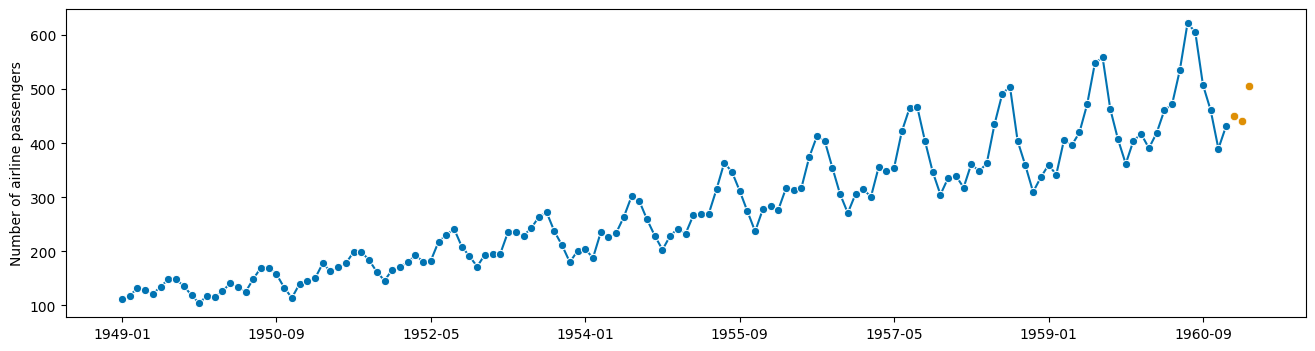

In [34]:
# this is a forecaster with the same interface as Polynomial Trend Forecaster
pipe.fit(y, fh=[1, 2, 3])
y_pred = pipe.predict()

plot_series(y, y_pred)

#### Example 2: classifier pipeline

works the same with classifiers or other estimator types!

In [35]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.transformations.series.exponent import ExponentTransformer

pipe = ExponentTransformer() * KNeighborsTimeSeriesClassifier()

# this constructs a ClassifierPipeline, which is also a classifier
pipe

ClassifierPipeline(classifier=KNeighborsTimeSeriesClassifier(),
                   transformers=[ExponentTransformer()])

In [36]:
from sktime.datasets import load_unit_test

X_train, y_train = load_unit_test(split="TRAIN")
X_test, _ = load_unit_test(split="TEST")

# this is a forecaster with the same interface as knn-classifier
# first applies exponent transform, then knn-classifier
pipe.fit(X_train, y_train)

ClassifierPipeline(classifier=KNeighborsTimeSeriesClassifier(),
                   transformers=[ExponentTransformer()])

## 3.3 Combining transformers, feature engineering <a class="anchor" id="section_3_3"></a>

transformers are natural pipeline components

* data processing steps
* feature engineering steps
* post processing steps

they can be combined in a number of other ways:

* pipelining = sequential chaining
* feature union = parallel, addition of features
* feature subsetting = selecting columns
* inversion = switch transform and inverse
* multiplexing = switching between transformers
* passthrough = switch on/ off

### Chaining transformers via `*`

In [37]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.summarize import SummaryTransformer

pipe = Differencer() * SummaryTransformer()

# this constructs a TransformerPipeline, which is also a transformer
pipe

TransformerPipeline(steps=[Differencer(), SummaryTransformer()])

In [38]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

X = _bottom_hier_datagen(no_levels=1, no_bottom_nodes=2)

# this is a transformer with the same interface
# first applies differencer, then summary transform
pipe.fit_transform(X)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,2.222222,33.636569,-101.0,87.00,-37.700,-16.000,3.50,22.25,43.000
1,48.111111,810.876526,-2680.3,2416.86,-826.462,-323.145,76.33,448.86,1021.974


compatible with sklearn transformers!

default applies sklearn transformer per individual time series as a data frame table

In [39]:
from sklearn.preprocessing import StandardScaler

pipe = Differencer() * StandardScaler()

pipe

TransformerPipeline(steps=[Differencer(),
                           TabularToSeriesAdaptor(transformer=StandardScaler())])

In [40]:
pipe.fit_transform(X)

passengers
l1_agg    timepoints            
l1_node01 1949-01      -0.066296
          1949-02       0.112704
          1949-03       0.351370
          1949-04      -0.155796
          1949-05      -0.304963
...                          ...
l1_node02 1960-08      -0.623659
          1960-09      -3.376512
          1960-10      -1.565994
          1960-11      -2.231567
          1960-12       1.210249

[288 rows x 1 columns]

pipeline-adaptor chains can be constructed manually:

* `sktime.transformations.compose.TransformerPipeline`
* `sktime.transformations.series.adapt.TabularToSeriesAdaptor` for `sklearn`

composites are compatible with `get_params` / `set_params` parameter interface:

In [41]:
pipe.get_params()

{'steps': [Differencer(),
  TabularToSeriesAdaptor(transformer=StandardScaler())],
 'Differencer': Differencer(),
 'TabularToSeriesAdaptor': TabularToSeriesAdaptor(transformer=StandardScaler()),
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'TabularToSeriesAdaptor__fit_in_transform': False,
 'TabularToSeriesAdaptor__transformer__copy': True,
 'TabularToSeriesAdaptor__transformer__with_mean': True,
 'TabularToSeriesAdaptor__transformer__with_std': True,
 'TabularToSeriesAdaptor__transformer': StandardScaler()}

### Feature union via `+`

In [42]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Differencer() + Lag()

# this constructs a FeatureUnion, which is also a transformer
pipe

FeatureUnion(transformer_list=[Differencer(), Lag()])

In [43]:
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

X = _bottom_hier_datagen(no_levels=1, no_bottom_nodes=2)

# applies both Differencer and Lag, returns transformed in different columns
pipe.fit_transform(X)

Differencer__passengers  Lag__lag_0__passengers
l1_agg    timepoints                                                 
l1_node01 1949-01                        0.00                  112.00
          1949-02                        6.00                  118.00
          1949-03                       14.00                  132.00
          1949-04                       -3.00                  129.00
          1949-05                       -8.00                  121.00
...                                       ...                     ...
l1_node02 1960-08                    -1920.80                38845.27
          1960-09                   -10759.42                28085.85
          1960-10                    -4546.78                23539.07
          1960-11                    -6114.52                17424.55
          1960-12                     3507.42                20931.97

[288 rows x 2 columns]

to retain the original columns, use the `Id` transformer:

In [44]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer() + Lag([1, 2], index_out="original")

pipe.fit_transform(X)

Id__passengers  Differencer__passengers  \
l1_agg    timepoints                                            
l1_node01 1949-01             112.00                     0.00   
          1949-02             118.00                     6.00   
          1949-03             132.00                    14.00   
          1949-04             129.00                    -3.00   
          1949-05             121.00                    -8.00   
...                              ...                      ...   
l1_node02 1960-08           38845.27                 -1920.80   
          1960-09           28085.85                -10759.42   
          1960-10           23539.07                 -4546.78   
          1960-11           17424.55                 -6114.52   
          1960-12           20931.97                  3507.42   

                      Lag__lag_1__passengers  Lag__lag_2__passengers  
l1_agg    timepoints                                                  
l1_node01 1949-01                        NaN                     NaN  
          1949-02                     112.00                     NaN  
          1949-03                     118.00                  112.00  
          1949-04                     132.00                  118.00  
          1949-05                     129.00                  132.00  
...                                      ...                     ...  
l1_node02 1960-08                   40766.07                30877.65  
          1960-09                   38845.27                40766.07  
          1960-10                   28085.85                38845.27  
          1960-11                   23539.07                28085.85  
          1960-12                   17424.55                23539.07  

[288 rows x 4 columns]

In [45]:
# parameter inspection
pipe.get_params()

{'flatten_transform_index': True,
 'n_jobs': None,
 'transformer_list': [Id(),
  Differencer(),
  Lag(index_out='original', lags=[1, 2])],
 'transformer_weights': None,
 'Id': Id(),
 'Differencer': Differencer(),
 'Lag': Lag(index_out='original', lags=[1, 2]),
 'Id___output_convert': 'auto',
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'Lag__flatten_transform_index': True,
 'Lag__freq': None,
 'Lag__index_out': 'original',
 'Lag__keep_column_names': False,
 'Lag__lags': [1, 2]}

### Subset input columns via `[colname]`

let's say we want to apply `Differencer` to column 0, and `Lag` to column 1

also we keep the original columns for illustration

In [46]:
from sktime.utils._testing.hierarchical import _make_hierarchical

X = _make_hierarchical(
    hierarchy_levels=(2, 2), n_columns=2, min_timepoints=3, max_timepoints=3
)

X

c0        c1
h0   h1   time                          
h0_0 h1_0 2000-01-01  3.356766  2.649204
          2000-01-02  2.262487  2.204119
          2000-01-03  2.087692  2.186494
     h1_1 2000-01-01  4.311237  3.129610
          2000-01-02  3.190134  1.747807
          2000-01-03  4.231399  2.483151
h0_1 h1_0 2000-01-01  4.356575  3.550554
          2000-01-02  2.865619  2.783107
          2000-01-03  3.781770  2.619533
     h1_1 2000-01-01  3.113704  1.000000
          2000-01-02  2.673081  2.561047
          2000-01-03  1.000000  2.953516

In [47]:
from sktime.transformations.compose import Id
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Id() + Differencer()["c0"] + Lag([1, 2], index_out="original")["c1"]

pipe.fit_transform(X)

Id__c0    Id__c1  TransformerPipeline_1__c0  \
h0   h1   time                                                        
h0_0 h1_0 2000-01-01  3.356766  2.649204                   0.000000   
          2000-01-02  2.262487  2.204119                  -1.094279   
          2000-01-03  2.087692  2.186494                  -0.174795   
     h1_1 2000-01-01  4.311237  3.129610                   0.000000   
          2000-01-02  3.190134  1.747807                  -1.121103   
          2000-01-03  4.231399  2.483151                   1.041265   
h0_1 h1_0 2000-01-01  4.356575  3.550554                   0.000000   
          2000-01-02  2.865619  2.783107                  -1.490956   
          2000-01-03  3.781770  2.619533                   0.916151   
     h1_1 2000-01-01  3.113704  1.000000                   0.000000   
          2000-01-02  2.673081  2.561047                  -0.440623   
          2000-01-03  1.000000  2.953516                  -1.673081   

                      TransformerPipeline_2__lag_1__c1  \
h0   h1   time                                           
h0_0 h1_0 2000-01-01                               NaN   
          2000-01-02                          2.649204   
          2000-01-03                          2.204119   
     h1_1 2000-01-01                               NaN   
          2000-01-02                          3.129610   
          2000-01-03                          1.747807   
h0_1 h1_0 2000-01-01                               NaN   
          2000-01-02                          3.550554   
          2000-01-03                          2.783107   
     h1_1 2000-01-01                               NaN   
          2000-01-02                          1.000000   
          2000-01-03                          2.561047   

                      TransformerPipeline_2__lag_2__c1  
h0   h1   time                                          
h0_0 h1_0 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          2.649204  
     h1_1 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          3.129610  
h0_1 h1_0 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          3.550554  
     h1_1 2000-01-01                               NaN  
          2000-01-02                               NaN  
          2000-01-03                          1.000000

auto-generated names can be replaced by using `FeatureUnion` explicitly:

In [48]:
from sktime.transformations.compose import FeatureUnion

pipe = FeatureUnion(
    [
        ("original", Id()),
        ("diff", Differencer()["c0"]),
        ("lag", Lag([1, 2], index_out="original")),
    ]
)

pipe.fit_transform(X)

original__c0  original__c1  diff__c0  lag__lag_1__c0  \
h0   h1   time                                                               
h0_0 h1_0 2000-01-01      3.356766      2.649204  0.000000             NaN   
          2000-01-02      2.262487      2.204119 -1.094279        3.356766   
          2000-01-03      2.087692      2.186494 -0.174795        2.262487   
     h1_1 2000-01-01      4.311237      3.129610  0.000000             NaN   
          2000-01-02      3.190134      1.747807 -1.121103        4.311237   
          2000-01-03      4.231399      2.483151  1.041265        3.190134   
h0_1 h1_0 2000-01-01      4.356575      3.550554  0.000000             NaN   
          2000-01-02      2.865619      2.783107 -1.490956        4.356575   
          2000-01-03      3.781770      2.619533  0.916151        2.865619   
     h1_1 2000-01-01      3.113704      1.000000  0.000000             NaN   
          2000-01-02      2.673081      2.561047 -0.440623        3.113704   
          2000-01-03      1.000000      2.953516 -1.673081        2.673081   

                      lag__lag_1__c1  lag__lag_2__c0  lag__lag_2__c1  
h0   h1   time                                                        
h0_0 h1_0 2000-01-01             NaN             NaN             NaN  
          2000-01-02        2.649204             NaN             NaN  
          2000-01-03        2.204119        3.356766        2.649204  
     h1_1 2000-01-01             NaN             NaN             NaN  
          2000-01-02        3.129610             NaN             NaN  
          2000-01-03        1.747807        4.311237        3.129610  
h0_1 h1_0 2000-01-01             NaN             NaN             NaN  
          2000-01-02        3.550554             NaN             NaN  
          2000-01-03        2.783107        4.356575        3.550554  
     h1_1 2000-01-01             NaN             NaN             NaN  
          2000-01-02        1.000000             NaN             NaN  
          2000-01-03        2.561047        3.113704        1.000000

### turning log transform into exp transform via invert `~`

In [49]:
import numpy as np

from sktime.transformations.series.boxcox import LogTransformer

log = LogTransformer()

exp = ~log

# this behaves like an "e to the power of" transformer now
exp.fit_transform(np.array([1, 2, 3]))

array([ 2.71828183,  7.3890561 , 20.08553692])

### autoML structure compositors: multiplexer switch `¦` and on/off switch `-`

expose decisions as parameter

* do we want differencer *or* lag? for tuning later
* do we want [differencer and lag] or [original features and lag] ? for tuning later

In [50]:
# differencer or lag

from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.lag import Lag

pipe = Differencer() | Lag()

pipe.get_params()

{'selected_transformer': None,
 'transformers': [Differencer(), Lag()],
 'Differencer': Differencer(),
 'Lag': Lag(),
 'Differencer__lags': 1,
 'Differencer__memory': 'all',
 'Differencer__na_handling': 'fill_zero',
 'Lag__flatten_transform_index': True,
 'Lag__freq': None,
 'Lag__index_out': 'extend',
 'Lag__keep_column_names': False,
 'Lag__lags': 0}

the `selected_transformer` parameter exposes the choice:

does this behave as `Lag` or `Differencer`?

In [51]:
# switch = Lag -> this is a Lag transformer now!
pipe.set_params(selected_transformer="Lag")

MultiplexTransformer(selected_transformer='Lag',
                     transformers=[Differencer(), Lag()])

In [52]:
# switch = Lag -> this is a Differencer now!
pipe.set_params(selected_transformer="Differencer")

MultiplexTransformer(selected_transformer='Differencer',
                     transformers=[Differencer(), Lag()])

similar, on/off switch with `~`

same as multiplexer between wrapped transformer and `Id`

In [53]:
optional_differencer = -Differencer()

# this behaves as Differencer now
optional_differencer

OptionalPassthrough(transformer=Differencer())

In [54]:
# this is now just the identity transformer
optional_differencer.set_params(passthrough=True)

OptionalPassthrough(passthrough=True, transformer=Differencer())

## 3.4 Technical details - transformer types and signatures <a class="anchor" id="section_3_4"></a>

This section explains the different types of transformers found in `sktime` in detail.

There are four main types of transformation in `sktime`:

* transforming a series/sequence into scalar- or category-valued features. Examples: `tsfresh`, or extracting `mean` and `variance` overall.
* transforming a series into another series. Examples: detrending, smoothing, filtering, lagging.
* transforming a panel into another panel. Examples: principal component projection; applying individual series-to-series transformation to all series in the panel.
* transforming a pair of series into a scalar value. Examples: dynamic time warping distance between series/sequences; generalized alignment kernel between series/sequences.

Notably, the first three (series to primitive features, series to series, panel to panel) are covered by the same base class template and module. We call these transformers "time series transformers", or, simply, "transformers".
Kernels and distances for time series and sequences have the same mathematical signature and differ only in mathematical properties (e.g., definiteness assumptions) - they are covered by the more abstract scientific type of "pairwise transformer".

Below, we give an overview in sub-sections:
* reviewing common data container formats for series and panels
* showcasing the signature of time series transformers, that transform a single series or panel
* showcasing the signature of pairwise transformers, that transform a pair of series to a scalar, e.g., distances or kernels
* how to search `sktime` for transformers of a certain type

### 3.4.1 Data container format<a class="anchor" id="section_3_4_1"></a>

`sktime` transformers apply to individual time series and panels. Panels are collections of time series, and we refer to each time series in a panel as an "instance" of the panel.
This is formalized as abstract "scientific types" `Series` and `Panel`, with multiple possible in-memory representations, so-called "mtypes".

For the purpose of this tutorial, we will be working with the most common mtypes. For more details and formal data type specifications, see the "datatypes and datasets" tutorial.

`Series` are commonly represented as:

* `pandas.Series` for univariate time series and sequences
* `pandas.DataFrame` for uni- or multivariate time series and sequences

The `Series.index` and `DataFrame.index` are used for representing the time series or sequence index. `sktime` supports pandas integer, period and timestamp indices.

`Panel`-s are commonly represented as:
* a `pandas.DataFrame` in a specific format, defined by the `pd-multiindex` mtype. This has a 2-level index, for time points and instances
* a `list` of `pandas.DataFrame`, where all `pandas.DataFrame` are in the `Series` format. The different `list` elements are the different instances

In either case, the "time" index must be a `sktime` compatible time index type, as for `Series`.

In [55]:
from sktime.datatypes import get_examples

In [56]:
# example of a univariate series
get_examples("pd.Series", "Series")[0]

0    1.0
1    4.0
2    0.5
3   -3.0
Name: a, dtype: float64

In [57]:
# example of a multivariate series
get_examples("pd.DataFrame", "Series")[1]

,a,b
0,1.0,3.000000
1,4.0,7.000000
2,0.5,2.000000
3,-3.0,-0.428571


In [58]:
# example of a panel with mtype pd-multiindex
get_examples("pd-multiindex", "Panel")[0]

var_0  var_1
instances timepoints              
0         0               1      4
          1               2      5
          2               3      6
1         0               1      4
          1               2     55
          2               3      6
2         0               1     42
          1               2      5
          2               3      6

In [59]:
# example of the same panel with mtype df-list
get_examples("df-list", "Panel")[0]

[   var_0  var_1
 0      1      4
 1      2      5
 2      3      6,
    var_0  var_1
 0      1      4
 1      2     55
 2      3      6,
    var_0  var_1
 0      1     42
 1      2      5
 2      3      6]

`sktime` supports more mtypes, see the "datatypes and datasets" tutorial for more details.

### 3.4.2 General transformer signature - time series transformers<a class="anchor" id="section_3_4_2"></a>

Transformers for `Series` and `Panel` have the same high-level interface. Depending which data type they are more commonly used for, they are found either in the `transformations.series` or `transformations.panel` module. As said, this does not imply a separate interface.

The most important interface points of transformers are:

1. construction with parameters, this is as with any other `sktime` estimator
2. fitting the transformer, via `fit`
3. transforming data, via `transform`
4. inverse transforming, via `inverse_transform` - not all transformers have this interface point, since not all are invertible
5. updating the transformer, via `update` - not all transformers have this interface point (`update` is currently work in progress, as of v0.8.x, contributions are appreciated)

We show this using two example transformers below - one whose `transform` outputs `Series`, and one whose `transform` outputs primitive features (numbers or categories).

We will apply both transformations to the following `Series` and `Panel` data:

In [60]:
from sktime.datatypes import get_examples

# univariate series used in the examples
X_series = get_examples("pd.Series", "Series")[3]
# panel used in the examples
X_panel = get_examples("pd-multiindex", "Panel")[2]

In [61]:
X_series

0    1.0
1    4.0
2    0.5
3    3.0
Name: a, dtype: float64

In [62]:
X_panel

var_0
instances timepoints       
0         0               4
          1               5
          2               6

#### Example: transforming series to series

The Box-Cox transformer applies the Box-Cox transform to individual values in series or panels. At the start, the transformer needs to be constructed with parameter settings, this is the same as for any `sktime` estimator.

In [63]:
# constructing the transformer
from sktime.transformations.series.boxcox import BoxCoxTransformer

my_boxcox_trafo = BoxCoxTransformer(method="mle")

Now, we apply the constructed transformer `my_trafo` to a (single, univariate) series. First, the transformer is fitted:

In [64]:
# fitting the transformer
my_boxcox_trafo.fit(X_series)

BoxCoxTransformer()

Next, the transformer is applied, this results in a transformed series.

In [65]:
# transforming the series
my_boxcox_trafo.transform(X_series)

0    0.000000
1    1.636217
2   -0.640098
3    1.251936
Name: a, dtype: float64

Generally, the series passed to `transform` need not be the same as in `fit`, but if they are the same, the shorthand `fit_transform` can instead be used:

In [66]:
my_boxcox_trafo.fit_transform(X_series)

0    0.000000
1    1.636217
2   -0.640098
3    1.251936
Name: a, dtype: float64

The transformer can also be applied to `Panel` data.

In [67]:
my_boxcox_trafo.fit_transform(X_panel)

var_0
instances timepoints          
0         0           2.156835
          1           2.702737
          2           3.206011

Note: the `BoxCoxTransformer` used has applied the Box-Cox transform to every series in the panel individually,
but that need not be the case transformers in general.

#### Example: transforming series to primitive features

The summary transformer can be used to extract sample statistics such as mean and variance from a series. First, we construct the transformer:

In [68]:
# constructing the transformer
from sktime.transformations.series.summarize import SummaryTransformer

my_summary_trafo = SummaryTransformer()

As before, we can fit/apply with `fit`, `transform`, and `fit_transform`.

`SummaryTransformer` returns primitive features, hence the output will be a `pandas.DataFrame`, each row corresponding to one series in the input. 

If the input is a single series, the output of `transform` and `fit_transform` will be a one-row, nine-column `DataFrame`, corresponding to the nine-number-summary of that one series:

In [69]:
my_summary_trafo.fit_transform(X_series)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
0,2.125,1.652019,0.5,4.0,0.65,0.875,2.0,3.25,3.7


If the input is a panel, the output of `transform` and `fit_transform` will be a `DataFrame` with as many rows as the `Panel` had series. The `i`th row has the summary statistics of the `i`th series in the panel `X_panel`:

In [70]:
my_summary_trafo.fit_transform(X_panel)

,mean,std,min,max,0.1,0.25,0.5,0.75,0.9
instances,,,,,,,,,
0,5.0,1.0,4.0,6.0,4.2,4.5,5.0,5.5,5.8


#### Transformers with series/panel output vs primitive output

Whether `transform` will return time series like objects (`Series` or `Panel`) or primitives (i.e. a `pandas.DataFrame`) can be checked by using the `"scitype:transform-output"` tag. This is `"Series"` for behaviour as in the first example (`BoxCoxTransformer`), and `"Primitives"` for behaviour as in the second example (`SummaryTransformer`):

In [71]:
my_boxcox_trafo.get_tag("scitype:transform-output")

'Series'

In [72]:
my_summary_trafo.get_tag("scitype:transform-output")

'Primitives'

Use of tags to characterize and search for transformers will be discussed in more detail in section 4.

NOTE: currently not all transformers are refactored to accept both `Series` to `Panel` arguments, the above may hence not fully work for all transformers. Contributions to the transformer refactor are very much appreciated.

### 3.4.3 General transformer signature - pairwise series transformers<a class="anchor" id="section_3_4_3"></a>

Pairwise series transformers model mathematical objects of signature `(Series, Series) -> float`, or, in mathematical notation, $$\texttt{series} \times\texttt{series}\rightarrow\mathbb{R}$$
Common examples are distances between series, or (positive definite) kernels on series.

Pairwise transformers have a parametric constructor, like any other `sktime` object. The transformation is achieved by the method `transform`, or, equivalently, for brevity, by a call to the constructed object.

The method `transform` always returns a 2D `numpy.ndarray`, and can be called in multiple ways:
* with two `Series` arguments `X, X2`, in which case a 1 x 1 array is returned. Denote this function by `t(X, X2)`
* with two `Panel` arguments `X`, `X2`, in which case an `m x n` array is returned, where `m` is the number of instances in `X` and `n` is the number of instances in `X2`. The `(i,j)`-th entry corresponds to `t(Xi, X2j)`, where `Xi` is the `i`-th `Series` in the `Panel` `X`, and `X2j` is the `j`-th `Series` in the `Panel` `X2`.
* with one `Series` and one `Panel` argument, in which case the `Series` is interpreted as a 1-element `Panel`, with return as above.
* with one single argument, `Series` or `Panel`, in which case `X` and `X2` are assumed to be the same as the one argument, with behaviour as above.

We show these in a few examples below.

In [73]:
from sktime.datatypes import get_examples

# unviariate series used in the examples
X_series = get_examples("pd.Series", "Series")[0]
X2_series = get_examples("pd.Series", "Series")[1]
# panel used in the examples
X_panel = get_examples("pd-multiindex", "Panel")[0]

First, we construct the pairwise transformer with parameters. In this case, the pairwise transformer is a distance (the mean Euclidean distance):

In [74]:
# constructing the transformer
from sktime.dists_kernels import AggrDist, ScipyDist

# mean of paired Euclidean distances
my_series_dist = AggrDist(ScipyDist(metric="euclidean"))

We can then evaluate the distance by `transform` or direct call:

In [75]:
# evaluate the metric on two series, via transform
my_series_dist.transform(X_series, X2_series)

array([[2.6875]])

In [76]:
# evaluate the metric on two series, by direct call - this is the same
my_series_dist(X_series, X2_series)

array([[2.6875]])

In [77]:
# evaluate the metric on two identical panels of three series
my_series_dist(X_panel, X_panel)

array([[ 1.25707872, 17.6116986 , 13.12667685],
       [17.6116986 , 22.85520736, 21.30677498],
       [13.12667685, 21.30677498, 16.55183053]])

In [78]:
# this is the same as providing only one argument
my_series_dist(X_panel)

array([[ 1.25707872, 17.6116986 , 13.12667685],
       [17.6116986 , 22.85520736, 21.30677498],
       [13.12667685, 21.30677498, 16.55183053]])

In [79]:
# one series, one panel
# we subset X_panel to univariate, since the distance in question
#     cannot compare series with different number of variables
my_series_dist(X_series, X_panel[["var_1"]])

array([[ 4.375     , 21.04166667, 17.04166667]])

Pairwise transformers are composable, and use the familiar `get_params` interface, just like any other `sktime` object and `scikit-learn` estimator:

In [80]:
my_series_dist.get_params()

{'aggfunc': None,
 'aggfunc_is_symm': False,
 'transformer': ScipyDist(),
 'transformer__colalign': 'intersect',
 'transformer__metric': 'euclidean',
 'transformer__metric_kwargs': None,
 'transformer__p': 2,
 'transformer__var_weights': None}

### 3.4.4 General transformer signature - pairwise transformers<a class="anchor" id="section_3_4_4"></a>

`sktime` also provides functionality for pairwise transformers on tabular data, i.e., mathematical objects of signature `(DataFrame-row, DataFrame-row) -> float`, or, in mathematical notation, $$\mathbb{R}^n \times\mathbb{R}^n\rightarrow\mathbb{R}$$.
Common examples are distances between series, or (positive definite) kernels on series.

The behaviour is as for series transformers, evaluation is callable by `transform(X, X2)` or a direct call.

Inputs to `transform` of a pairwise (tabular) transformer must always be `pandas.DataFrame`.
The output is an `m x n` matrix, a 2D `np.ndarray`, with `m = len(X), n=len(X2)`. 
The `(i,j)`-th entry corresponds to `t(Xi, X2j)`, where `Xi` is the `i`-th row of `X`, and `X2j` is the `j`-th row of `X2`.
If `X2` is not passed, it defaults to `X`.

Example:

In [81]:
from sktime.datatypes import get_examples

# we retrieve some DataFrame examples
X_tabular = get_examples("pd.DataFrame", "Series")[1]
X2_tabular = get_examples("pd.DataFrame", "Series")[1][0:3]

In [82]:
# constructing the transformer
from sktime.dists_kernels import ScipyDist

# mean of paired Euclidean distances
my_tabular_dist = ScipyDist(metric="euclidean")

In [83]:
# obtain matrix of distances between each pair of rows in X_tabular, X2_tabular
my_tabular_dist(X_tabular, X2_tabular)

array([[ 0.        ,  5.        ,  1.11803399],
       [ 5.        ,  0.        ,  6.10327781],
       [ 1.11803399,  6.10327781,  0.        ],
       [ 5.26831112, 10.20704039,  4.26004216]])

### 3.4.5 Searching for transformers<a class="anchor" id="section_3_4_5"></a>

As with all `sktime` objects, we can use the `registry.all_estimators` utility to display all transformers in `sktime`.

The relevant scitypes are:
* `"transformer"` for all transformers (as in Section 2.2)
* `"transformer-pairwise"` for all pairwise transformers on tabular data (as in Section 2.4)
* `"transformer-panel"` for all pairwise transformers on panel data (as in Section 2.3)

To filter transformers (`"transformer"` scitype) further by input and output, use tags, most importantly:
* `"scitype:transform-output"` - the output scitype that the transform produces. `Series` for time series, `Primitives` for primitive features (float, categories).
* `"scitype:instancewise"` - whether transform uses all samples or acts by instance. If `True`, this is simply a vectorized operation per series. If `False`, then fitting on a single series does not have the same result as fitting on multiple.

These and further tags will be explained in more detail in Section 2.

In [84]:
from sktime.registry import all_estimators

In [85]:
# listing all pairwise panel transformers - distances, kernels on time series
all_estimators("transformer", as_dataframe=True)

,name,object
0,ADICVTransformer,<class 'sktime.transformations.series.adi_cv.A...
1,Aggregator,<class 'sktime.transformations.hierarchical.ag...
2,AutoCorrelationTransformer,<class 'sktime.transformations.series.acf.Auto...
3,BKFilter,<class 'sktime.transformations.series.bkfilter...
4,Bollinger,<class 'sktime.transformations.series.bollinge...
...,...,...
123,TruncationTransformer,<class 'sktime.transformations.panel.truncatio...
124,VmdTransformer,<class 'sktime.transformations.series.vmd.VmdT...
125,WhiteNoiseAugmenter,<class 'sktime.transformations.series.augmente...
126,WindowSummarizer,<class 'sktime.transformations.series.summariz...


In [86]:
# now subset to transformers that extract scalar features
all_estimators(
    "transformer",
    as_dataframe=True,
    filter_tags={"scitype:transform-output": "Primitives"},
)

,name,object
0,ADICVTransformer,<class 'sktime.transformations.series.adi_cv.A...
1,Catch22,<class 'sktime.transformations.panel.catch22.C...
2,Catch22Wrapper,<class 'sktime.transformations.panel.catch22wr...
3,DistanceFeatures,<class 'sktime.transformations.panel.compose_d...
4,FittedParamExtractor,<class 'sktime.transformations.panel.summarize...
5,MatrixProfile,<class 'sktime.transformations.panel.matrix_pr...
6,MiniRocket,<class 'sktime.transformations.panel.rocket._m...
7,MiniRocketMultivariate,<class 'sktime.transformations.panel.rocket._m...
8,MiniRocketMultivariateVariable,<class 'sktime.transformations.panel.rocket._m...
9,MultiRocket,<class 'sktime.transformations.panel.rocket._m...


In [87]:
# listing all pairwise (tabular) transformers - distances, kernels on vectors/df-rows
all_estimators("transformer-pairwise", as_dataframe=True)

,name,object
0,ScipyDist,<class 'sktime.dists_kernels.scipy_dist.ScipyD...


In [88]:
# listing all pairwise panel transformers - distances, kernels on time series
all_estimators("transformer-pairwise-panel", as_dataframe=True)

,name,object
0,AggrDist,<class 'sktime.dists_kernels.compose_tab_to_pa...
1,CombinedDistance,<class 'sktime.dists_kernels.algebra.CombinedD...
2,ConstantPwTrafoPanel,<class 'sktime.dists_kernels.dummy.ConstantPwT...
3,CtwDistTslearn,<class 'sktime.dists_kernels.ctw.CtwDistTslearn'>
4,DistFromAligner,<class 'sktime.dists_kernels.compose_from_alig...
5,DistFromKernel,<class 'sktime.dists_kernels.dist_to_kern.Dist...
6,DtwDist,<class 'sktime.dists_kernels.dtw._dtw_sktime.D...
7,DtwDistTslearn,<class 'sktime.dists_kernels.dtw._dtw_tslearn....
8,DtwDtaidistMultiv,<class 'sktime.dists_kernels.dtw._dtw_dtaidist...
9,DtwDtaidistUniv,<class 'sktime.dists_kernels.dtw._dtw_dtaidist...


## 3.5 Extension guide - implementing your own transformer <a class="anchor" id="section_3_5"></a>

`sktime` is meant to be easily extensible, for direct contribution to `sktime` as well as for local/private extension with custom methods.

To extend `sktime` with a new local or contributed transformer, a good workflow to follow is:

1. read through the [transformer extension template](https://github.com/alan-turing-institute/sktime/blob/main/extension_templates/transformer.py) - this is a `python` file with `todo` blocks that mark the places in which changes need to be added.
2. optionally, if you are planning any major surgeries to the interface: look at the [base class architecture](https://github.com/alan-turing-institute/sktime/blob/main/sktime/transformations/base.py) - note that "ordinary" extension (e.g., new algorithm) should be easily doable without this.
3. copy the transformer extension template to a local folder in your own repository (local/private extension), or to a suitable location in your clone of the `sktime` or affiliated repository (if contributed extension), inside `sktime.transformations`; rename the file and update the file docstring appropriately.
4. address the "todo" parts. Usually, this means: changing the name of the class, setting the tag values, specifying hyper-parameters, filling in `__init__`, `_fit`, `_transform`, and optional methods such as `_inverse_transform` or `_update` (for details see the extension template). You can add private methods as long as they do not override the default public interface. For more details, see the extension template.
5. to test your estimator manually: import your estimator and run it in the workflows in Section 2.2; then use it in the compositors in Section 2.3.
6. to test your estimator automatically: call `sktime.tests.test_all_estimators.check_estimator` on your estimator. You can call this on a class or object instance. Ensure you have specified test parameters in the `get_test_params` method, according to the extension template.

In case of direct contribution to `sktime` or one of its affiliated packages, additionally:
* Add yourself as an author and/or a maintainer for the new estimator file(s), via `"authors"` and `"maintainers"` tag.
* create a pull request that contains only the new estimators (and their inheritance tree, if it's not just one class), as well as the automated tests as described above.
* in the pull request, describe the estimator and optimally provide a publication or other technical reference for the strategy it implements.
* before making the pull request, ensure that you have all necessary permissions to contribute the code to a permissive license (BSD-3) open source project.

## 3.6 Summary <a class="anchor" id="section_3_6"></a>

* transformers are data processing steps with unified interface - `fit`, `transform`, and optional `inverse_transform`

* used as pipeline components for any learning task, forecasting, classification

* different types by input/output - time series, primitives, pairs of time series, panels/hierarchical.

* find transformers by tags such as `scitype:transform-output` and `scitype:instancewise` using `all_estimators`

* rich composition syntax - `*` for pipe, `+` for featureunion, `[in, out]` for variable subset, `|` for multiplex/switch

* `sktime` provides easy-to-use extension templates for transformers, build your own, plug and play

---

### Credits: notebook 3 - transformers

notebook creation: fkiraly

transformer pipelines & compositors: fkiraly, mloning, miraep8\
forecaster pipelines: fkiraly, aiwalter\
classifier/regressor pipelines: fkiraly\
transformer base interface: mloning, fkiraly\
dunder interface: fkiraly, miraep8

Based on design ideas: sklearn, magrittr, mlr, mlj